 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - ordenar descendentemente los items similares => lista 1
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [2]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(PATH)

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [5]:
df.shape

(883636, 12)

In [6]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/meta_AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF(PATH)
df_meta.head()


,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
tablas_combinadas = pd.merge(df, df_meta, on='asin', how='left')
pd.set_option('display.max_columns', None)
tablas_combinadas.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title,brand,feature,rank,date,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,Milliongadgets(TM) Earring Safety Backs For Fi...,NaN,NaN,"2,081,098inClothing,ShoesJewelry(",fishhook,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
tablas_combinadas['vote'][0]

nan

In [39]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in tablas_combinadas.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el tablas_combinadasFrame 'tablas_combinadas'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    tablas_combinadas['combined_text'] = tablas_combinadas[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

In [43]:
tablas_combinadas = tablas_combinadas[:50]

In [23]:
tablas_combinadas['similar_item'].value_counts()

similar_item
[{'asin': '', 'href': '', 'name': 'Winter White Ivory Thick Slouchy Knit Oversized Beanie Cap Hat,One Size,Indie Pink', 'img': 'https://images-na.ssl-images-amazon.com/images/I/61EUG32%2BRQL._SL500_AC_SS350_.jpg', 'features': {'Customer Rating': '4 out of 5 stars

(261)', 'Price': '$9.99', 'Shipping': 'Eligible for FREE Shipping', 'Sold By': 'NY FASHION DEALS'}}, {'asin': 'B0765C1995', 'href': '/dp/B0765C1995/ref=psdc_10304191_t1_B00O0ZTS04', 'name': 'C.C Unisex Colorful Confetti Soft Stretch Cable Knit Beanie Skull Cap - Mint', 'img': 'https://images-na.ssl-images-amazon.com/images/I/610wvM24E3L._SL500_AC_SS350_.jpg', 'features': {'Customer Rating': '4 out of 5 stars

(7)', 'Price': '$10.71', 'Shipping': 'Eligible for FREE Shipping', 'Sold By': 'Keebon International'}}, {'asin': 'B077BHT7FW', 'href': '/dp/B077BHT7FW/ref=psdc_10304191_t2_B00O0ZTS04', 'name': 'C.C Unisex Colorful Confetti Soft Stretch Cable Knit Beanie Skull Cap - Dark Purple', 'img': 'https://images-na.ssl

Text(0, 0.5, 'Count')

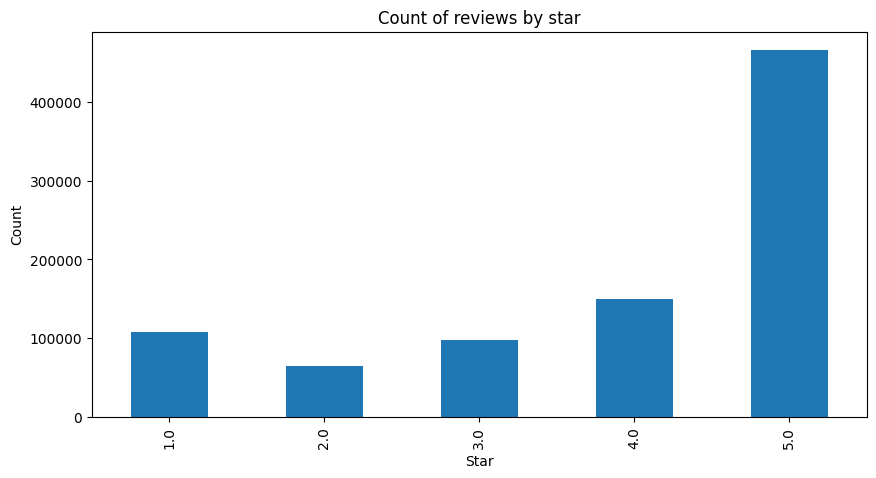

In [17]:
ax = tablas_combinadas['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [52]:
example = tablas_combinadas['reviewText'][39]
example

'Wonderful item. I have purchased several of these. They last forever unless you lose them.  I am happy with my purchase Buxton is made to last.'

In [53]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Wonderful',
 'item',
 '.',
 'I',
 'have',
 'purchased',
 'several',
 'of',
 'these',
 '.',
 'They',
 'last',
 'forever',
 'unless',
 'you',
 'lose',
 'them',
 '.',
 'I',
 'am',
 'happy',
 'with',
 'my',
 'purchase',
 'Buxton',
 'is',
 'made',
 'to',
 'last',
 '.']

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Excellent', 'JJ'), ('product', 'NN'), ('!', '.')]

In [13]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Excellent/JJ product/NN !/.)


In [14]:
reviewer = tablas_combinadas['reviewerID'].value_counts()
reviewer

reviewerID
A3G5KDMFNRUXHB    40
A3JBQHQZEZPQK4    36
A1RRX286ZRI830    32
A2PBHVTPTIIGKR    31
A2GP4EJIAA2OE0    29
                  ..
A3F8ZWBOAZUZE2     1
A2HI8EO6V5PST8     1
A3GKQ3VSTGLAHW     1
A3HEDQXYV9OCVR     1
A2RSX9E79DUHRX     1
Name: count, Length: 749233, dtype: int64

In [20]:
productos = tablas_combinadas['asin'].value_counts()
productos

asin
B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
              ... 
B00VT2YP22       1
B00VT2OM4I       1
B00VT2YZYU       1
B00VT02V7K       1
B01HJG5NMW       1
Name: count, Length: 186189, dtype: int64

In [19]:
overall_mean = tablas_combinadas.groupby('asin')['overall'].mean().sort_values(ascending=False)
overall_mean

asin
0764443682    5.0
B00Y88IVK6    5.0
B00Y8MUW7M    5.0
B00Y8LF6S8    5.0
B00Y8FXRX0    5.0
             ... 
B0105EWJWC    1.0
B01DK76L5M    1.0
B01DK76L52    1.0
B01DK76L2A    1.0
B010WGHX8S    1.0
Name: overall, Length: 186189, dtype: float64

In [62]:
tokenized_rows = []
for row in tablas_combinadas['combined_text']:
    data_tokens = nltk.word_tokenize(row)
    pos_tag = nltk.pos_tag(data_tokens)
    ne_chunk = nltk.chunk.ne_chunk(pos_tag)
    tokenized_rows.append(ne_chunk)
tablas_combinadas['tokenized_combined_text'] = tokenized_rows
    

C:\Users\coraj\AppData\Local\Temp\ipykernel_19700\2838406169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tablas_combinadas['tokenized_combined_text'] = tokenized_rows


In [64]:
tablas_combinadas['tokenized_combined_text'][0].pprint()

(S
  Milliongadgets/NNS
  (/(
  TM/NNP
  )/)
  Earring/NNP
  Safety/NNP
  Backs/NNP
  For/IN
  (PERSON Fish/NNP Hook/NNP Small/NNP Earrings/NNP)
  (/(
  150/CD
  )/)
  nan/NN
  perfect/JJ
  replacements/NNS
  !/.
  !/.
  nan/NN)
